# GRU (Gated Recurrent Unit) の実装

このノートブックでは、LSTMと同様に長期依存性の問題を解決するために提案された、もう一つの主要なゲート付きリカレントニューラルネットワークであるGRU (Gated Recurrent Unit) のアーキテクチャと動作原理を学びます。
NumPyを使ってGRUセルの主要な計算ステップを実装し、その後PyTorchの`nn.GRU`モジュールを使ってモデルを構築・学習させます。

**参考論文:**
*   Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning phrase representations using RNN encoder-decoder for statistical machine translation. *arXiv preprint arXiv:1406.1078*. (GRUが提案された主要論文の一つ)
*   Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. *arXiv preprint arXiv:1412.3555*. (GRUの性能評価)

**このノートブックで学ぶこと:**
1.  GRUのアーキテクチャ：更新ゲートとリセットゲート。
2.  LSTMとの比較を通じたGRUの構造と特徴の理解。
3.  NumPyによるGRUセルの順伝播計算の実装。
4.  PyTorchの `nn.GRU` モジュールを使ったGRUモデルの実装と学習。

**前提知識:**
*   LSTMの基本的な構造と動作原理の理解（前のノートブック）。
*   PyTorchの基本的な使い方。

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

print(f"NumPy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NumPy Version: 1.26.4
PyTorch Version: 2.7.0+cpu
Using device: cpu


## 2. GRU (Gated Recurrent Unit) の導入

GRUは、LSTMと同様にゲート機構を用いてRNNの長期依存性問題を解決しようとするモデルですが、LSTMよりもシンプルな構造をしています。LSTMには3つのゲート（忘却、入力、出力）と独立したセル状態がありましたが、GRUは主に2つのゲート（リセットゲートと更新ゲート）を持ち、セル状態と隠れ状態を統合しています。

### 2.1 GRUセルの構造と計算ステップ

時刻 $t$ におけるGRUセルの計算は、以下の主要なステップで行われます（$\sigma$ はSigmoid関数、$\tanh$ はハイパボリックタンジェント関数）。

*   **入力 ($x_t$):** 時刻 $t$ の外部入力。
*   **前時刻の隠れ状態 ($h_{t-1}$):** 1つ前のGRUセルからの出力。

1.  **リセットゲート ($r_t$):**
    前時刻の隠れ状態 $h_{t-1}$ のうち、どの情報を「リセット」（無視）して新しい候補隠れ状態の計算に使うかを決定します。
    $r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$
    ここで、$[h_{t-1}, x_t]$ は $h_{t-1}$ と $x_t$ を結合したベクトルです。

2.  **更新ゲート ($z_t$):**
    前時刻の隠れ状態 $h_{t-1}$ と、新しく計算される候補隠れ状態 $\tilde{h}_t$ の情報をどの割合で混ぜ合わせて、現時刻の隠れ状態 $h_t$ を作るかを決定します。LSTMの忘却ゲートと入力ゲートの役割を一部統合したような働きをします。
    $z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$

3.  **候補隠れ状態 ($\tilde{h}_t$):**
    リセットゲート $r_t$ によって調整された前時刻の情報と、現在の入力 $x_t$ を使って、新しい隠れ状態の候補を計算します。
    $\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$
    ここで $\odot$ は要素ごとの積です。リセットゲート $r_t$ が0に近い要素は、$h_{t-1}$ の対応する情報が候補計算時に無視されることになります。

4.  **現時刻の隠れ状態 ($h_t$):**
    更新ゲート $z_t$ を使って、前時刻の隠れ状態 $h_{t-1}$ と候補隠れ状態 $\tilde{h}_t$ を線形補間のように組み合わせます。
    $h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$
    *   $z_t$ が0に近い要素では、主に $h_{t-1}$ の情報が保持されます。
    *   $z_t$ が1に近い要素では、主に新しい候補 $\tilde{h}_t$ の情報が取り込まれます。

**パラメータ:**
GRUセルの学習可能なパラメータは、各ゲートと候補隠れ状態の計算に使われる重み行列 ($W_r, W_z, W_h$) とバイアスベクトル ($b_r, b_z, b_h$) です。LSTMと比較してパラメータ数が少ないことが特徴です。

**LSTMとの主な違い:**
*   **セル状態の有無:** GRUにはLSTMのような独立したセル状態がありません。隠れ状態 $h_t$ がその役割を兼ねています。
*   **ゲートの数:** LSTMは3つ（忘却、入力、出力）、GRUは2つ（リセット、更新）。
*   **出力ゲートの有無:** GRUには明示的な出力ゲートがありません。隠れ状態 $h_t$ がそのまま出力として使われます。

## 3. NumPyによるGRUセルの主要コンポーネント実装 (順伝播)
GRUセルの1タイムステップ分の順伝播をNumPyで実装してみましょう。

In [9]:
# 活性化関数 (再掲)
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

def tanh(x): 
    return np.tanh(x)

In [10]:
def initialize_gru_parameters(input_size, hidden_size, random_seed=42):
    ''' GRUのパラメータを初期化 '''

    if random_seed is not None:
        np.random.seed(random_seed)

    concat_size = input_size + hidden_size

    # リセットゲート
    Wr = np.random.randn(concat_size, hidden_size) * 0.01
    br = np.zeros((1, hidden_size))

    # 更新ゲート
    Wz = np.random.randn(concat_size, hidden_size) * 0.01
    bz = np.zeros((1, hidden_size))

    # 候補隠れ層
    Wh = np.random.randn(concat_size, hidden_size) * 0.01
    bh = np.zeros((1, hidden_size))

    parameters = {'Wr': Wr, 'br': br,
                  'Wz': Wz, 'bz': bz,
                  'Wh': Wh, 'bh': bh}
    return parameters    

In [11]:
def gru_forward_step(xt, h_prev, parameters):
    '''
    GRUセルの1タイムステップ分の順伝播
    Parameters:
        xt: 時刻tの入力 (1, input_size)
        h_prev: 前の隠れ状態 (1, hidden_size)
        parameters: GRUのパラメータ
    Returns:
        tuple: (ht, cache_t)
            ht: 時刻tの隠れ状態
            cache_t: 逆伝播で使う中間値
    '''
    Wr, br = parameters['Wr'], parameters['br']
    Wz, bz = parameters['Wz'], parameters['bz']
    Wh, bh = parameters['Wh'], parameters['bh']

    if xt.ndim == 1: xt = xt.reshape(1, -1)
    if h_prev.ndim == 1: h_prev = h_prev.reshape(1, -1)

    # xtとh_prevを結合
    concat_input = np.concatenate((h_prev, xt), axis=1)
    
    # リセットゲートの計算
    rt = sigmoid(np.dot(concat_input, Wr) + br)

    # 更新ゲートの計算
    zt = sigmoid(np.dot(concat_input, Wz) + bz)

    # 候補隠れ状態の計算
    h_prev_reset = rt * h_prev
    concat_input_for_h_tilde = np.concatenate((h_prev_reset, xt), axis=1)
    h_tilde_t = tanh(np.dot(concat_input_for_h_tilde, Wh) + bh)

    # 現時刻の隠れ状態の計算
    ht = (1 - zt) * h_prev + zt * h_tilde_t

    cache_t = {'xt': xt, 'h_prev': h_prev,
               'rt': rt, 'zt': zt, 'h_tilde_t': h_tilde_t,
               'ht': ht, 'concat_input': concat_input,
               'concat_input_for_h_tilde': concat_input_for_h_tilde}
    
    return ht, cache_t

In [12]:
# テスト
input_dim_gru = 3
hidden_dim_gru = 5 
params_gru = initialize_gru_parameters(input_dim_gru, hidden_dim_gru, random_seed=20)

xt_gru_test = np.random.randn(1, input_dim_gru)
h_prev_gru_test = np.random.randn(1, hidden_dim_gru)

ht_gru, cache_gru_t = gru_forward_step(xt_gru_test, h_prev_gru_test, params_gru)

print("xt_gru_test shape:", xt_gru_test.shape)
print("h_prev_gru_test shape:", h_prev_gru_test.shape)
print("\nht_gru (現隠れ状態) shape:", ht_gru.shape)
print("\nrt (リセットゲート):\n", cache_gru_t["rt"])
print("zt (更新ゲート):\n", cache_gru_t["zt"])
print("h_tilde_t (候補隠れ状態):\n", cache_gru_t["h_tilde_t"])

xt_gru_test shape: (1, 3)
h_prev_gru_test shape: (1, 5)

ht_gru (現隠れ状態) shape: (1, 5)

rt (リセットゲート):
 [[0.49292152 0.50725918 0.50139258 0.49848724 0.49618853]]
zt (更新ゲート):
 [[0.50240096 0.49836036 0.50185228 0.49162676 0.48884253]]
h_tilde_t (候補隠れ状態):
 [[-0.05602501 -0.00380308  0.01239558 -0.01486699  0.02527042]]


**BPTT for GRU:**
GRUのBPTTも、LSTMと同様に各ゲートと状態の更新式に対して連鎖律を適用して計算されます。LSTMよりゲート数が少ないため、計算は若干シンプルになりますが、依然として複雑です。PyTorchのようなフレームワークでは自動微分によって処理されます。

## 4. PyTorchによるGRUの実装と学習

PyTorchでは、`nn.GRU` モジュールを使ってGRU層を簡単に利用できます。

### 4.1 PyTorch `nn.GRU` の使い方
`nn.GRU` の基本的なインターフェースは `nn.RNN` や `nn.LSTM` と似ています。

*   **`nn.GRU` の初期化:**
    `gru_layer = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)`
    *   引数は`nn.RNN`とほぼ同じ。

*   **順伝播:**
    `outputs, h_n = gru_layer(input_sequence, h_initial)`
    *   `input_sequence`: 形状 `(batch_size, seq_length, input_size)` の入力テンソル。
    *   `h_initial` (オプション): 形状 `(num_layers, batch_size, hidden_size)` の初期隠れ状態テンソル。
    *   `outputs`: 形状 `(batch_size, seq_length, hidden_size)` の、各タイムステップにおける最後のGRU層の**隠れ状態 ($h_t$)** の出力。
    *   `h_n`: 形状 `(num_layers, batch_size, hidden_size)` の、シーケンス全体の最後のタイムステップにおける隠れ状態。
    (LSTMと異なり、GRUはセル状態を別途返しません。)

In [13]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, hn = self.gru(x, h0)
        y_pred = self.fc(out.contiguous().view(-1, self.hidden_size))
        y_pred = y_pred.view(out.size(0), out.size(1), -1)

        return y_pred, hn

In [14]:
# テスト
input_dim_pt_gru = 1
hidden_dim_pt_gru = 10 
output_dim_pt_gru = 1
num_gru_layers_pt = 1

model_pt_gru = SimpleGRU(input_dim_pt_gru, hidden_dim_pt_gru, output_dim_pt_gru, num_gru_layers_pt).to(device)
print("PyTorch SimpleGRU Model:\n", model_pt_gru)

# ダミー入力でテスト
batch_size_pt_gru = 5
seq_len_pt_gru = 10
dummy_x_pt_gru = torch.randn(batch_size_pt_gru, seq_len_pt_gru, input_dim_pt_gru).to(device)

pred_seq_pt_gru, last_h_pt_gru = model_pt_gru(dummy_x_pt_gru)
print("\nPyTorch GRU Dummy Input Shape:", dummy_x_pt_gru.shape)
print("PyTorch GRU Dummy Output Seq Shape:", pred_seq_pt_gru.shape)
print("PyTorch GRU Dummy Last Hidden Shape:", last_h_pt_gru.shape)

PyTorch SimpleGRU Model:
 SimpleGRU(
  (gru): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

PyTorch GRU Dummy Input Shape: torch.Size([5, 10, 1])
PyTorch GRU Dummy Output Seq Shape: torch.Size([5, 10, 1])
PyTorch GRU Dummy Last Hidden Shape: torch.Size([1, 5, 10])


### 4.2 簡単なシーケンス予測タスクでのPyTorch GRU学習 (Sin波予測)
LSTMのノートブックで使ったSin波予測タスクでGRUを学習させてみます。

In [15]:
# sin波データセットの生成 (LSTMノートブックから再掲)
def generate_sindata_gru(seq_length=20, num_sequences=1000, predict_steps=1):
    X_list, y_list = [], []
    for _ in range(num_sequences):
        start_phase = np.random.rand() * 2 * np.pi
        time_steps = np.linspace(start_phase, start_phase + (seq_length + predict_steps -1)*0.1, seq_length + predict_steps)
        data = np.sin(time_steps)
        X_list.append(data[:seq_length])
        y_list.append(data[seq_length : seq_length + predict_steps])
    X = np.array(X_list, dtype=np.float32).reshape(num_sequences, seq_length, 1)
    y = np.array(y_list, dtype=np.float32).reshape(num_sequences, predict_steps, 1)
    return X, y

seq_len_sindata_gru = 30
num_seq_sindata_gru = 2000
X_sindata_gru, y_sindata_gru = generate_sindata_gru(seq_length=seq_len_sindata_gru, num_sequences=num_seq_sindata_gru, predict_steps=1)

X_sindata_pt_gru = torch.from_numpy(X_sindata_gru).to(device)
y_sindata_pt_gru = torch.from_numpy(y_sindata_gru).to(device)

def get_batches_gru(X, y, batch_size): # (LSTMノートブックから再掲)
    n_batches = X.shape[0] // batch_size
    for i in range(n_batches):
        start = i * batch_size; end = start + batch_size
        yield X[start:end], y[start:end]

In [16]:
# モデル、損失関数、Optimizer
input_dim_sin_gru = 1
hidden_dim_sin_gru = 50 
output_dim_sin_gru = 1 
num_gru_layers_sin = 1

model_sindata_gru = SimpleGRU(input_dim_sin_gru, hidden_dim_sin_gru, output_dim_sin_gru, num_gru_layers_sin).to(device)
criterion_sindata_gru = nn.MSELoss()
optimizer_sindata_gru = optim.Adam(model_sindata_gru.parameters(), lr=0.005)

num_epochs_sindata_gru = 100
batch_size_sindata_gru = 50
print_every_sindata_gru = num_epochs_sindata_gru // 10
costs_sindata_gru = []

print(f"\nPyTorch GRU 学習開始 (Sin波予測, {hidden_dim_sin_gru} hidden units)...")
for epoch in range(num_epochs_sindata_gru + 1):
    model_sindata_gru.train()
    epoch_loss = 0
    num_batches_processed = 0
    for x_batch, y_batch in get_batches_gru(X_sindata_pt_gru, y_sindata_pt_gru, batch_size_sindata_gru):
        outputs_seq, _ = model_sindata_gru(x_batch)
        loss = criterion_sindata_gru(outputs_seq[:, -1, :], y_batch.squeeze(1)) 
        optimizer_sindata_gru.zero_grad()
        loss.backward()
        optimizer_sindata_gru.step()
        epoch_loss += loss.item()
        num_batches_processed += 1
    avg_epoch_loss = epoch_loss / num_batches_processed
    costs_sindata_gru.append(avg_epoch_loss)
    if epoch % print_every_sindata_gru == 0:
        print(f"Epoch {epoch}, Loss (MSE): {avg_epoch_loss:.6f}")



PyTorch GRU 学習開始 (Sin波予測, 50 hidden units)...
Epoch 0, Loss (MSE): 0.072497
Epoch 10, Loss (MSE): 0.000001
Epoch 20, Loss (MSE): 0.000000
Epoch 30, Loss (MSE): 0.000000
Epoch 40, Loss (MSE): 0.000000
Epoch 50, Loss (MSE): 0.000027
Epoch 60, Loss (MSE): 0.000001
Epoch 70, Loss (MSE): 0.000000
Epoch 80, Loss (MSE): 0.000000
Epoch 90, Loss (MSE): 0.000004
Epoch 100, Loss (MSE): 0.000000


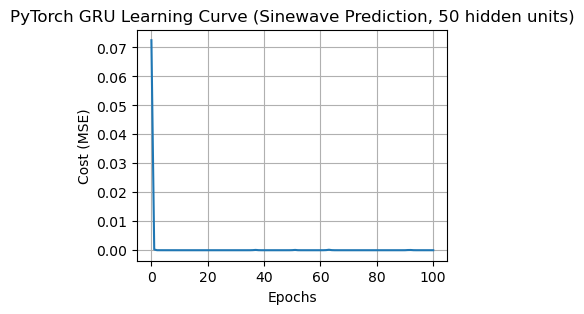

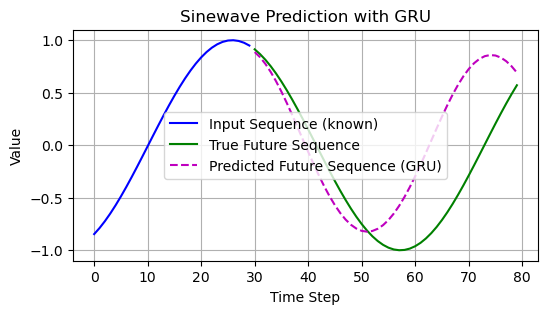

In [17]:
plt.figure(figsize=(4,3))
plt.plot(costs_sindata_gru)
plt.xlabel(f"Epochs"); plt.ylabel("Cost (MSE)")
plt.title(f"PyTorch GRU Learning Curve (Sinewave Prediction, {hidden_dim_sin_gru} hidden units)")
plt.grid(True); plt.show()

# 学習済みモデルで予測してプロット
model_sindata_gru.eval()
with torch.no_grad():
    X_test_sin_gru, y_test_sin_true_gru = generate_sindata_gru(seq_length=seq_len_sindata_gru, num_sequences=1, predict_steps=50)
    X_test_sin_pt_gru = torch.from_numpy(X_test_sin_gru).to(device)
    _, hn_gru = model_sindata_gru(X_test_sin_pt_gru) # 最後の隠れ状態を取得
    current_input_val_gru = X_test_sin_pt_gru[:, -1:, :]
    predicted_sequence_gru = []
    for _ in range(50): # 50ステップ先まで予測
        pred_out_gru, hn_gru = model_sindata_gru(current_input_val_gru, hn_gru)
        predicted_val_gru = pred_out_gru.item()
        predicted_sequence_gru.append(predicted_val_gru)
        current_input_val_gru = torch.tensor([[[predicted_val_gru]]], dtype=torch.float32).to(device)

plt.figure(figsize=(6,3))
total_len_plot_gru = seq_len_sindata_gru + 50
plt.plot(np.arange(seq_len_sindata_gru), X_test_sin_gru.ravel(), 'b-', label='Input Sequence (known)')
plt.plot(np.arange(seq_len_sindata_gru, total_len_plot_gru), y_test_sin_true_gru.ravel(), 'g-', label='True Future Sequence')
plt.plot(np.arange(seq_len_sindata_gru, total_len_plot_gru), predicted_sequence_gru, 'm--', label='Predicted Future Sequence (GRU)')
plt.title("Sinewave Prediction with GRU")
plt.xlabel("Time Step"); plt.ylabel("Value"); plt.legend(); plt.grid(True); plt.show()

## 5. 考察

*   **GRUの構造と計算:**
    *   NumPyによる順伝播実装を通じて、GRUの2つの主要なゲート（リセットゲートと更新ゲート）がどのように連携し、前時刻の隠れ状態と現在の入力から新しい隠れ状態を生成するかを確認しました。
    *   リセットゲートは過去の情報をどの程度無視するかを制御し、更新ゲートは過去の情報と新しく計算された候補情報（入力に基づいて生成）をどの割合で組み合わせるかを制御します。
    *   LSTMと比較して、GRUは独立したセル状態を持たず、ゲートの数も少ないため、構造がよりシンプルです。

*   **PyTorchによるGRU実装の利便性:**
    *   `nn.GRU`モジュールは、LSTMと同様に、複雑な内部計算をカプセル化し、使いやすいインターフェースを提供します。BPTTも自動微分によって処理されます。

*   **LSTMとGRUの比較:**
    *   **構造の複雑さ:** GRUはLSTMよりもゲートが1つ少なく、セル状態も隠れ状態に統合されているため、パラメータ数が少なく、構造がシンプルです。
    *   **計算効率:** 一般的に、GRUはLSTMよりも計算が若干速い傾向があります。
    *   **性能:** 多くのタスクにおいて、LSTMとGRUは同程度の性能を示すことが多いと言われていますが、データセットやタスクの特性によってどちらが優れているかは変わることがあります。GRUの方がパラメータが少ないため、データ量が少ない場合に過学習しにくいという報告もありますが、一概には言えません。経験的には、まずLSTMを試し、計算資源や速度が問題になる場合にGRUを検討するというアプローチも取られます。
    *   **ゲートの役割の対応（概念的）:**
        *   GRUの**更新ゲート ($z_t$)** は、LSTMの忘却ゲート ($f_t$) と入力ゲート ($i_t$) の役割を一部組み合わせたものと見なせます。(1-$z_t$) が忘却する割合、$z_t$ が新しい情報を取り込む割合に対応します。
        *   GRUの**リセットゲート ($r_t$)** は、LSTMには直接対応するものがありませんが、新しい候補隠れ状態 $\tilde{h}_t$ を計算する際に、過去の隠れ状態 $h_{t-1}$ の影響をどの程度考慮するかを制御します。

*   **長期依存性の学習:**
    *   GRUもLSTMと同様に、ゲート機構によって勾配の流れを制御し、単純なRNNが苦手とする長期依存性を捉える能力が向上しています。

このノートブックでは、GRUの基本的なメカニズムと、PyTorchを使ったその応用例について学びました。LSTMとGRUは、リカレントニューラルネットワークにおける重要な進歩であり、様々なシーケンスモデリングタスクで成功を収めています。
次の段階では、これらのリカレント層をEncoder-Decoder構造に組み込んだり、さらに発展したAttention機構を持つTransformerモデルに進んでいくのが良いでしょう。